In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np

c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 256


In [3]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

170499072it [00:31, 5456807.19it/s]                               


Extracting ./cifar10\cifar-10-python.tar.gz to ./cifar10


# CIFAR10 classes

In [4]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Show some images

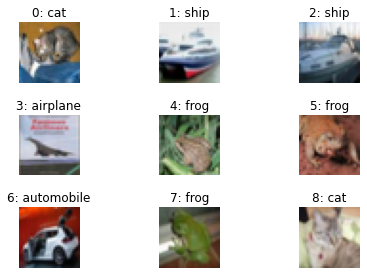

In [5]:
images_batch, labels_batch = next(iter(dataloader))

def plot_9_imgs(batch, labels):
	n = 3
	offset = 0  # We can start showing images at some offset untill (offset + n*n)

	fig, ax = plt.subplots(n, n)
	fig.tight_layout()

	for row in range(n):
		for col in range(n):
			cur_ax = ax[row, col]
			img_i = row*n + col + offset

			cur_ax.set_axis_off()
			cur_ax.set_title(str(img_i) + ": " + str(dataset.classes[labels[img_i]]))
			o = batch[img_i].numpy().transpose(1, 2, 0)
			cur_ax.imshow(o)

plot_9_imgs(images_batch, labels_batch)

# Load pre-trained ResNet

In [6]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.eval()

for x in resnet18.named_children():
	print(x)

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kerne

# Information

Notice RESNET18 model last layer which is Fully Connected.

We want to generalize the output of the model to list of probabilities to each class.

So we need to add softmax activation at the end.

Furthermore, we only have 10 classes, so last layer should be 10 out features instead of 10.

# Get prediction

What we see here is prediction to the 1000 original classes. We don't want that.

In [7]:
prediction = resnet18(images_batch)
softmax = nn.Softmax(dim=1)  # The model has no softmax activation / any activation at the end. So we apply softmax to get rid of negative probabilities.
p = softmax(prediction)
p = p.argmax(dim=1)
print(p)

tensor([793, 628, 296, 554, 276, 500, 793,  58, 500, 296, 628, 458, 500, 458,
        755, 793, 202,  45, 901,  69, 287, 549, 296, 509, 226, 946, 825, 999,
        500, 669,  69, 761,   9, 794, 970,   5, 500, 918, 591, 276, 222,  58,
        297, 896, 976, 350, 500, 884, 276,  69, 296, 977, 922,  69, 876, 628,
        825, 350, 270, 918, 922, 500,  58, 519,  69, 318, 500, 922,  75, 296,
        746, 847, 922, 435,  49, 310, 549, 961, 350, 922, 922, 922, 971, 810,
        918, 350,  58, 810, 628, 510, 977,  75, 119, 999, 170, 793, 266, 769,
        549, 922, 500, 276,  45, 961, 918, 922,  58, 500, 500, 999, 276, 918,
        922, 202, 858, 825, 318, 233, 793, 500, 435, 876, 336, 922, 977,  58,
        510, 500, 118, 922, 500, 918, 628, 922, 554, 500, 202, 118,  58, 141,
         69, 520, 739,  45, 296, 793, 500, 680, 289, 728, 918, 120,  69, 458,
        153, 305, 794, 500, 118, 977, 549, 918,  69, 297,  49, 977, 296, 977,
        793, 977, 350, 922, 500, 628, 510, 918,  65, 500, 500, 9

# Change output features from 1000 to 10

In [8]:
resnet18.fc = nn.Linear(in_features=512, out_features=10)

for x in resnet18.named_children():
	print(x)

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kerne

Last layer now has 10 features

In [9]:
prediction = resnet18(images_batch)
softmax = nn.Softmax(dim=1)  
labels_prediction = torch.max(softmax(prediction), dim=1)
print(labels_prediction.indices)

tensor([1, 1, 1, 6, 1, 9, 2, 0, 9, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 2,
        0, 6, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 9, 1, 1, 0, 1, 1, 2, 1, 1,
        0, 1, 6, 1, 1, 1, 1, 1, 1, 1, 0, 7, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 7, 2, 1, 7, 1, 0, 1, 1, 2, 1, 0, 6, 1, 0, 0,
        0, 5, 5, 5, 1, 0, 2, 9, 1, 1, 0, 1, 3, 6, 0, 1, 0, 0, 9, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 5, 1, 1, 1, 6, 3, 1, 1, 2, 1, 0, 1, 2, 1, 1,
        1, 9, 0, 3, 1, 6, 1, 1, 1, 1, 1, 0, 1, 9, 6, 1, 5, 1, 1, 0, 1, 9, 1, 1,
        6, 1, 1, 1, 1, 1, 1, 1, 0, 9, 7, 1, 5, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 6, 1, 1, 0, 1, 0, 1, 1, 9, 1, 7, 2, 6, 1,
        1, 1, 7, 0, 1, 1, 1, 1, 0, 6, 5, 1, 9, 1, 0, 3, 9, 1, 1, 1, 0, 1, 6, 6,
        1, 1, 7, 1, 1, 1, 6, 1, 0, 1, 9, 6, 0, 3, 0, 1])


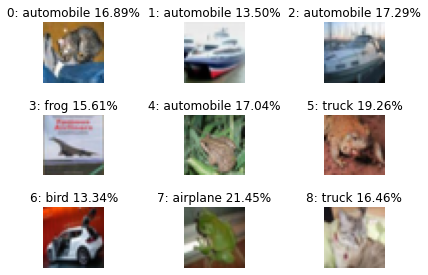

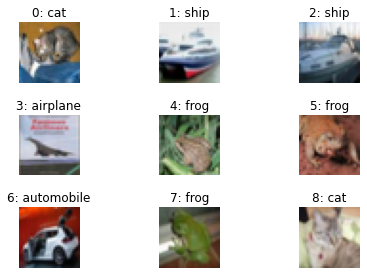

In [10]:
n = 3
fig, ax = plt.subplots(n, n)
fig.tight_layout()

for row in range(n):
	for col in range(n):
		cur_ax = ax[row, col]
		img_i = row*n + col

		label = dataset.classes[labels_prediction.indices[img_i]]

		prob = labels_prediction.values[img_i].item() * 100 # Get probability of the image being of the class
		prob = '%.2f' % prob # Show only 2 decimal places

		title = f"{img_i}: {label} {prob}%"

		cur_ax.set_axis_off()
		cur_ax.set_title(str(title))
		o = images_batch[img_i].numpy().transpose(1, 2, 0)
		cur_ax.imshow(o)

plot_9_imgs(images_batch, labels_batch)